# WOBCOVID corpus supplementary notebook

This notebook serves as a companion to the manually annotated WOB corpus for the DocSplitting challenge. The notebook discusses the origins of,creation and annotation of the dataset and also provides several rudimentary statistics for the corpus. Apart from this, several simple baselines are also run on the corpus to provide first pointers on the difficulty of the dataset for very simple baselines. 

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from typing import List, Union
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import f1_score
from IPython.display import display, Markdown, Latex
from fastDamerauLevenshtein import damerauLevenshtein

# Import the metric file for the metrics reported in the paper
from metricutils import *

## Index
1. [Dataset](#dataset)
   - 1.1 [Dataset origins](#origins)
   - 1.2 [Creation process](#creation)
   - 1.3 [Annotation process & IAA](#IAA)
2. [Dataset Exploration](#exploration)
3. [Baseline Performance](#baselines)
    - 3.1 [Extreme Baselines](#extreme_baselines)
    - 3.2 [Mean and Median Baselines](#mean_baselines)
4. [Conclusion](#conclusion)

<a id="dataset" />

# Dataset

<a id="origins" />

## Dataset origins 

The dataset was collected from Covid Wob requests regarding covid, from which a subset of documents was selected for document boundary annotation for teh PSS task. All streams in the dataset have roughly thirty documents in them. Some streams were longer, and were splitted up into even pieces to all fit the number of 30 pages.


In total, the datasets consists of 16 streams of documents, containing roughly 30 documents per stream. Although the stream themselves are all made up of consecutive documents which cannot be easily automatically splitted, there are lists available for the stream, so called 'inventarislijsten' or inventory lists, that detail the contents of the large files and also provide a list with the documents present in the stream. These tables were converted to csv using `tabular.io` and some manual post processing to correct any mistakes from the pdf to csv conversion process.

<a id='creation' />

## Dataset creation

The original streams in the datset were collected as pdf documents containing all the documents. In order to convert these to workable formats for the PSS methods, the dataset had to be converted. The first transformation that was done was the conversion of the pdf files to a collection of png files where each png file is one page from the large stream pdf file. This conversion was done with the `pdftopppm` tool from the Poppler package. For the quality of the outputted png files we used a dpi of 300 for both both the x and y directions.

To extract OCR text from the separate png files, `tesseract` was used, where we used 5.1.0, the latest version of tesseract at the time of writing. For the binarization method we used the Sauvola method, as several tests showed that this gave the best peformance of the OCR engine on the images.

<a id="IAA" />

## Inter annotator agreement

To measure the quality of the overall annotations, five short streams where created, and these were given to two annotators each, where they had to annotate the starting page of each document, as in the longer streams. For each of the five streams, Cohen's kappa was calculated for each of the sets, and the average kappa over the five pairs of streams is also given.

In [2]:
from sklearn.metrics import cohen_kappa_score

In [3]:
# The streams for the calculation of the inter annotator agreement scores are located in the 'IAA_streams' folder. Each stream is identified by the 
# 'short_X' prefix, where 'A' and 'B' are used to identify the different annotators.

# First we read in the csv files from the folders
def get_inventory_list(folder: str) -> pd.DataFrame:
    """
    This function takes as input the folder containing the inventarislijst and returns
    the pandas dataframe from the read csv file.
    """
  
    items = os.listdir(folder)
  
    # The annotated item will have a '.csv' extension
    inventory_list = [item for item in items if item[-4:] == '.csv'][0]

    dataframe = pd.read_csv(os.path.join(folder, inventory_list), sep=',')
    return dataframe



In [4]:
# The next step is the comparison of the folder of the same stream
# We write a function that calculates this.

def calculate_kappa_stream(folder1: str, folder2: str) -> float:
    """
    This function takes as input the the folders containing the csv files.
    It compares the 'Startin Page in PDF Viewer' columns, and calculates
    the kappa scoring using ...
    """
    df_1 = get_inventory_list(folder1)
    df_2 = get_inventory_list(folder2) 

    # New we get the label columns
    labels_1 = df_1['Starting Page in PDF Viewer']
    labels_2 = df_2['Starting Page in PDF Viewer']

    assert len(labels_1) == len(labels_2)

    return cohen_kappa_score(labels_1, labels_2)

In [5]:
def get_kappa_for_all_pairs(list_of_pair_filenames: List[List] )-> pd.Series:
    """
    This function takes as input a list where each element is itself a list
    with two elements, namely the filepaths to both the versions of the annotation
    set that will be compared using the kappa score. The function returns a series
    with the filepath as index and the IAA score as value.

    """
    all_scores = {}
    for annotation_1, annotation_2 in list_of_pair_filenames:
        kappa_score = calculate_kappa_stream(annotation_1, annotation_2)
        all_scores[annotation_1] = kappa_score

    return pd.Series(all_scores)



In [6]:
agreement_stream_sets = [('IAA_streams/short_1_A', 'IAA_streams/short_1_B'),
             ('IAA_streams/short_2_A', 'IAA_streams/short_2_B'),
             ('IAA_streams/short_3_A', 'IAA_streams/short_3_B'),
             ('IAA_streams/short_4_A', 'IAA_streams/short_4_B'),
             ('IAA_streams/short_5_A', 'IAA_streams/short_5_B')]

In [7]:
# Now we can run the IAA scores for all streams, we return the dataframe itself and claculate the mean later, so that we can
# inspect each pair in a bit more detail.

In [8]:
display(Markdown("<b>Table with the annotator scores for all the streams sets</b>"))
IAA_table = get_kappa_for_all_pairs(agreement_stream_sets)
display(IAA_table)
display(Markdown("<b>Mean Kappa score for all sets is</b> %.2f" % IAA_table.mean()))

<b>Table with the annotator scores for all the streams sets</b>

IAA_streams/short_1_A    0.619565
IAA_streams/short_2_A    0.933610
IAA_streams/short_3_A    1.000000
IAA_streams/short_4_A    1.000000
IAA_streams/short_5_A    1.000000
dtype: float64

<b>Mean Kappa score for all sets is</b> 0.91

### Conclusion of the IAA analysis

We can see from the scores on the pairs that for both annotation sets 3 and 5 both the annotators were in perfect agreement, thus this needs no further checking. However, for annotation sets 1 and 2, and especially 1, there are differences, warranting a small investigation to see why these differences exist. In short_2 there was a small type, a '19' was put in instead of a '39'. This is an incidental mistake and therefore the long version annotation of this annotator does not need to be checked.

## Other corrections

Apart from the calculation of the inter annotator agreement scores, some more checks were performed after the stream had been annotated with the starting pages. The main check that was conducted was during the conversion of the starting pages of each document to the document sizes of each document. For this conversion the starting page of the previous page was subtracted from the starting page of the current document. In this conversion, we check that each resulting size is larger than 0, as of course negative document sizes do not exist. We were able to filter add 2 typo's that were made on one of the annotated streams, these were correctly manually.

In [9]:
def fixedpage(gold_bin_vec: np.array, document_size: int) -> np.array:
    """
    This function can be used to construct predictions of a fixed number of pages for each document.
    The input is the binary vector of the gold standard and the number of pages i.e. document
    size
    """
    out = np.zeros(shape=(len(gold_bin_vec)))
    # now all indices at index % document_size == document_size-1 are 1 (to account for 0 index)
    out[np.arange(len(gold_bin_vec)) % document_size == 0] = 1
    return out

In [10]:
def read_json(fname):
    with open (fname, 'r') as json_file:
        contents = json.load(json_file)
    return contents

<a id="exploration" />

# Dataset Exploration


In this section we explore that dataset by plotting various statistics about it, such as the average number of documents per stream and the average number of pages per docuemnt.

In [26]:
import seaborn as sns
# Here we load both the ocred text as well as the json files containing the annotated boundaries of the documents.
wobcovid_corpus_json =  read_json('dataset/Doclengths_of_the_individual_docs_TEST.json')
wobcovid_ocr_text = pd.read_csv('dataset/ocred_text.csv.gz')

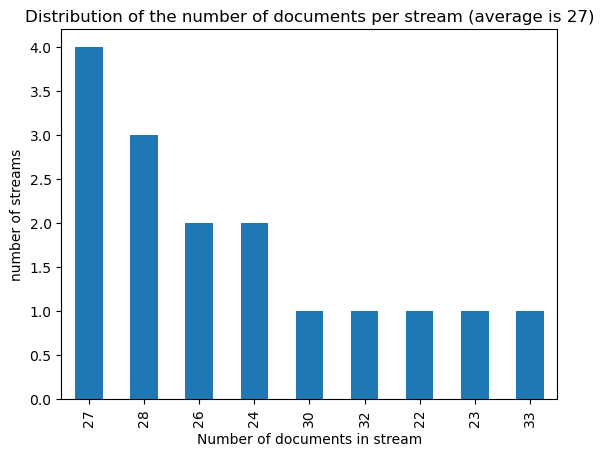

In [27]:
# Let's first make a plot of the distribution of the stream sizes and also plot
# the distribution of the nubmer of documents per page.

wobcovid_stream_lengths = [len(stream) for stream in wobcovid_corpus_json.values()]
pd.Series(wobcovid_stream_lengths).value_counts().plot(kind='bar', title="Distribution of the number of documents per stream (average is %d)" % pd.Series(wobcovid_stream_lengths).mean(),
                                                      xlabel="Number of documents in stream", ylabel="number of streams")
plt.show()


We can see that the number of documents per stram various between 22 and 32 and that most documents have a length of 27 documents.

Apart from the number of documents in each stream, we also report the number of pages in each stream, and the distribution of the number of pages in each document.

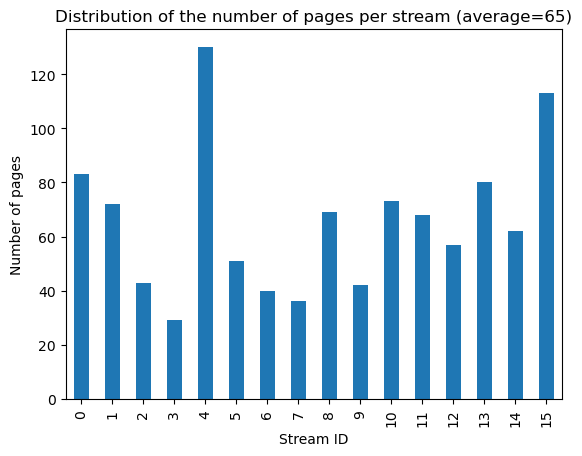

In [32]:
# Plot of the number of pages in each stream.
number_of_pages = wobcovid_ocr_text.groupby('name').size()
ax = number_of_pages.plot(kind='bar', title='Distribution of the number of pages per stream (average=%d)' % number_of_pages.mean(),
                         xlabel='Stream ID', ylabel='Number of pages')
ax.set_xticklabels(labels=range(len(number_of_pages)))
plt.show()

The above plot shows us the distribution of the number of pages per stream for all streams, where we can see that there is quite some variance in the number of pages per stream.

Finally, we we also plot the average document length, to see if there is a large imbalance in the document size.

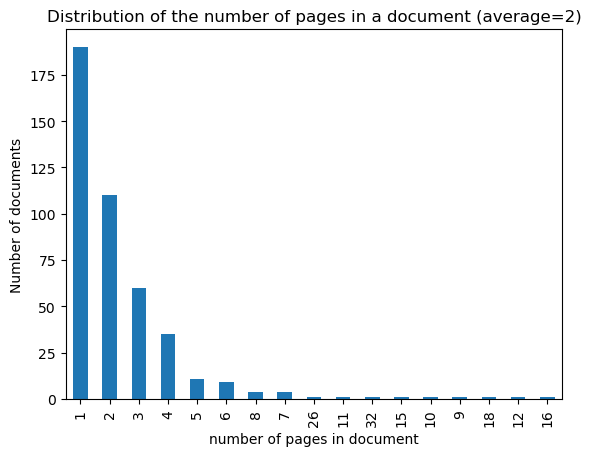

In [14]:
document_lengths = []
for stream in wobcovid_corpus_json.values():
    document_lengths.extend(stream)
    
document_lengths_ser = pd.Series(document_lengths)
document_lengths_ser.value_counts().plot(kind='bar', title="Distribution of the number of pages in a document (average=%d)" % document_lengths_ser.mean(),
                                        xlabel='number of pages in document', ylabel='Number of documents')
plt.show()

As we can see from the above figure, the number of pages in a document is highly skewed, as most documents contain only one page, with most of the other containing les than five pages.

<a id='baselines' />

# Baseline Performance

In this section we will run several simple baseline models on the wobcovid dataset, to see what the performance of those simple models is, and what this can tell us about the difficulty of the PSS task for this specific dataset.
We stick with very simple baselines here, we will use two extreme baselines (assume each document is of length one or assume each stream contains only one document) and baselines where we use the mean and median number of documents in the corpus as the number of documents in each stream. For all the baselines, we show the mean P, R and F1 scores for all the metrics discussed in our paper, and we also show the KDE distributions of the metrics.

For the KDE metric plots, we omit metrics in which there is no variance in the scores, as this causes errors in the plotting function, and such a KDE would not be very informative anyway, as the value can than simply be read from the results table which is also provided.

<a id='extreme_baselines'/>

## Extreme Baselines

In [15]:
# Voor extreme baselines is het gewoon een vectors van nullen of enen (behalve de eerste pagina)
def extreme_baseline(gold_standard_json: dict, kind: str='singletons'):
    """
    This method predicts document boundaries using an extreme prediction,
    namely only single page documents, or 1 document per stream.
    This paramter kind is used to specify this, and can take the values of 'singletons' and 'giant'
    
    """
    # Initialize the dict that will hold the scores
    stream_predictions = {}
    
    for i, (doc_id, stream) in enumerate(gold_standard_json.items()):
        # convert the data to binary vectors
        bin_vec = length_list_to_bin(stream)

        # get the prediction
        if kind == 'singletons':
            # only singletons mean every entry is a 1
            prediction = np.ones(shape=(len(bin_vec)))
        elif kind == 'giant':
            prediction = np.zeros(shape=(len(bin_vec)))
            prediction[0]  = 1 # Only the first element is a one to signal the start of the stream
        stream_predictions[doc_id] = prediction
    
    # we return the predictions so we can calculate the scores later
    return stream_predictions
            
        

In [16]:
singleton_predictions = extreme_baseline(wobcovid_corpus_json, kind='singletons')
giant_predictions = extreme_baseline(wobcovid_corpus_json, kind='giant')

In [18]:
# Now we can use the evaluation suite from the metricutils file to calculate the scores for the predictions we just made.
# the `evaluation_report` function that we use requires the gold standard to be in the binary format, so we will
# use the length_list_to_bin function to convert the gold standard.

In [17]:
gold_standard_binary = {key:length_list_to_bin(val) for key, val in wobcovid_corpus_json.items()}

First we will show the evaluation report for the singleton extreme predictions.

<b> Mean scores of the evaluation metrics for the extreme case of predicting only single page documents </b>

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Boundary,0.47,1.00,0.62,432.0,0.44-0.5,1.0-1.0,0.59-0.65
Bcubed,1.00,0.47,0.58,432.0,1.0-1.0,0.44-0.5,0.55-0.61
WindowDiff,0.18,0.18,0.18,432.0,0.16-0.2,0.16-0.2,0.16-0.2
Block,0.24,0.45,0.30,432.0,0.21-0.27,0.42-0.48,0.27-0.33
Weighted Block,0.24,0.45,0.30,432.0,0.21-0.27,0.42-0.48,0.27-0.33


<b> KDE Plots of the scores of the evaluation metrics for the extreme case of predicting only single page documents </b>

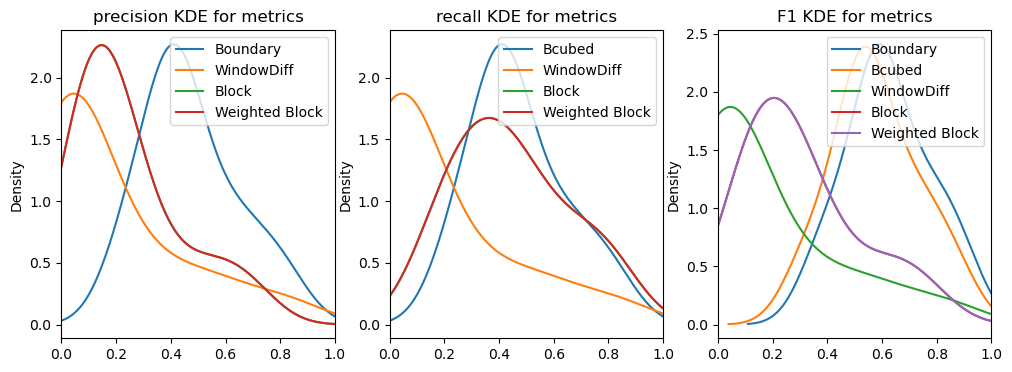

In [19]:
evaluation_report(gold_standard_binary, singleton_predictions, title="the extreme case of predicting only single page documents")

We can see that the baseline that only predictions single page documents achieves quite decent scores on the dataset. Of course, this can be large explaned by the large imbalance in the dataset that we discussed earlier, were most streams contain only one page, which of course means a baseline predicting only single page documents get really good scors.

Next, we wil plot the results of predicting that each stream consists of only one document.

<b> Mean scores of the evaluation metrics for the extreme case of predicting one document per stream </b>

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Boundary,1.00,0.04,0.07,432.0,1.0-1.0,-0.06-0.14,-0.06-0.2
Bcubed,0.06,1.00,0.11,432.0,-0.06-0.18,1.0-1.0,-0.04-0.26
WindowDiff,0.19,0.19,0.19,432.0,-0.0-0.38,-0.0-0.38,-0.0-0.38
Block,0.00,0.00,0.00,432.0,0.0-0.0,0.0-0.0,0.0-0.0
Weighted Block,0.00,0.00,0.00,432.0,0.0-0.0,0.0-0.0,0.0-0.0


<b> KDE Plots of the scores of the evaluation metrics for the extreme case of predicting one document per stream </b>

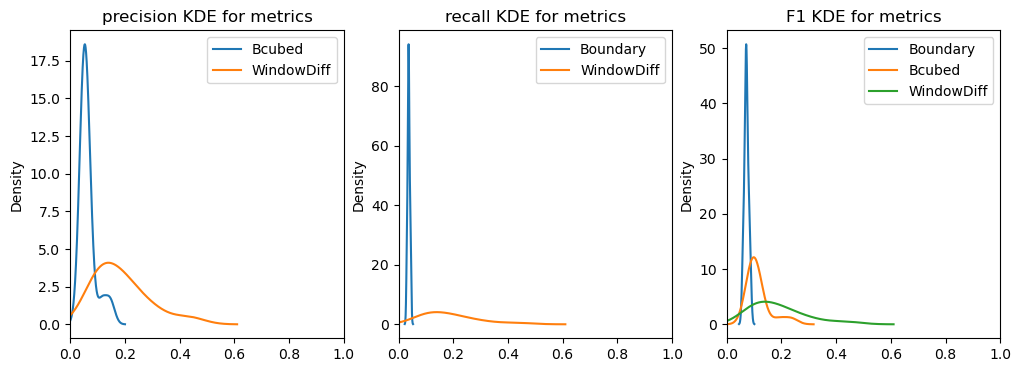

In [20]:
evaluation_report(gold_standard_binary, giant_predictions, title="the extreme case of predicting one document per stream")

For the baseline that predicts that each stream consists of only one document, we see that the scores are very low for all models (at least the F1 scores). This can again be explained by the dstribution of the number of documents per stream in the dataset, as streams that consists of only one document are ver uncommon.

<a id="mean_baselines">

## Mean and median baselines

Although the singleton and giant cluster predictions are interesting, they don't provide us with a very detailed understanding of the datase. For this reason, we also run some more informed baselines, using the mean and median number of pages in a stream.

In [21]:
# First we calculate the mean and median number of pages in the dataset 
all_docs = []
for stream in wobcovid_corpus_json.values():
    all_docs.extend(stream)
mean_num_pages = pd.Series(all_docs).mean()
median_num_pages = int(pd.Series(all_docs).median())
print("Mean: %.2f, median: %d" % (mean_num_pages, median_num_pages))

Mean: 2.43, median: 2


We can see the for the wobcovid datset the mean and mean number of pages per document is very close together, and when rounded they both equal 2. As this would mean we end up with exactly the same results of the two versions, we just predict using the mean number of pages per document and draw conclusions from that.

In [22]:
def corpus_level_baseline(gold_standard_json: dict, kind: str = 'mean'):
    """
    This method can be used to make the corpus stream and corpus median baselines.
    The input to the method is the gold standard dictionary in the length list format, and
    a string specifying whether mean or meidan should be used. the options are 'mean' and 'median'
    
    """
    all_docs = []
    for stream in gold_standard_json.values():
        all_docs.extend(stream)
    mean_num_pages = int(pd.Series(all_docs).mean())
    median_num_pages = int(pd.Series(all_docs).median())

    stream_predictions_corpus = {}
    for i, (doc_id, stream) in enumerate(gold_standard_json.items()):
        bin_vec = length_list_to_bin(stream)
        if kind == 'mean':
            baseline = fixedpage(bin_vec, mean_num_pages)
        elif kind == 'median':
            baseline = fixedpage(bin_vec, median_num_pages)
            
        stream_predictions_corpus[doc_id] = baseline
    return stream_predictions_corpus

In [23]:
corpus_mean_preds = corpus_level_baseline(wobcovid_corpus_json, kind='mean')
corpus_median_preds = corpus_level_baseline(wobcovid_corpus_json, kind='median')

<b> Mean scores of the evaluation metrics for a baseline using the mean document size of the corpus as the fixed document size </b>

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Boundary,0.48,0.51,0.48,432.0,0.44-0.52,0.47-0.55,0.44-0.52
Bcubed,0.77,0.62,0.60,432.0,0.73-0.81,0.58-0.66,0.56-0.64
WindowDiff,0.35,0.35,0.35,432.0,0.31-0.39,0.31-0.39,0.31-0.39
Block,0.13,0.13,0.13,432.0,0.1-0.16,0.1-0.16,0.1-0.16
Weighted Block,0.20,0.22,0.20,432.0,0.17-0.23,0.18-0.26,0.17-0.23


<b> KDE Plots of the scores of the evaluation metrics for a baseline using the mean document size of the corpus as the fixed document size </b>

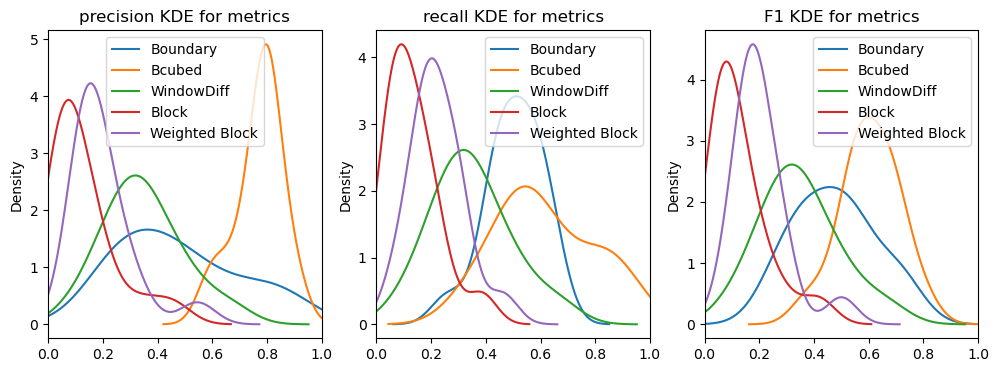

In [24]:
evaluation_report(gold_standard_binary, corpus_mean_preds, title="a baseline using the mean and median document size of the corpus as the fixed document size")

The above results show the performance of a model predicting each document to have the the median number of pages of the corpus. We can see that this gives pretty decent performances for most metrics, although the weighted block F1 scores are still not very high. We also see that most of the baselines have a nice normal-like distribution.

<a id="conclusion" />

# Conclusion

In this notebook we presented the WOBCOVID corpus and explained its origins, the creation and annotation process, and evaluated the quality of the annotations by calculating cohen's kappa. Furthermore, we did a small dataset exploration of the dataset, and ran some very simple baselines on the dataset.